In [2]:
import dkist
import cv2
import numpy as np 
from astropy.io import fits
import matplotlib.pyplot as plt
from dask_image.ndfilters import median_filter, sobel
import dask
import dask.array as da
from dask.distributed import Client, progress
from astropy.visualization import (ImageNormalize, 
        AsymmetricPercentileInterval, AsinhStretch)

In [3]:
vbi_dir = "/cluster/scratch/zhuyin/pid_1_123/BJOLO/"

In [4]:
dkist_dataset = dkist.load_dataset(vbi_dir)

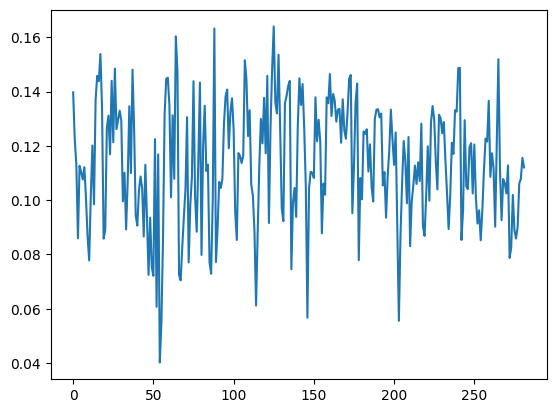

In [5]:
plt.plot(dkist_dataset.headers["ATMOS_R0"])

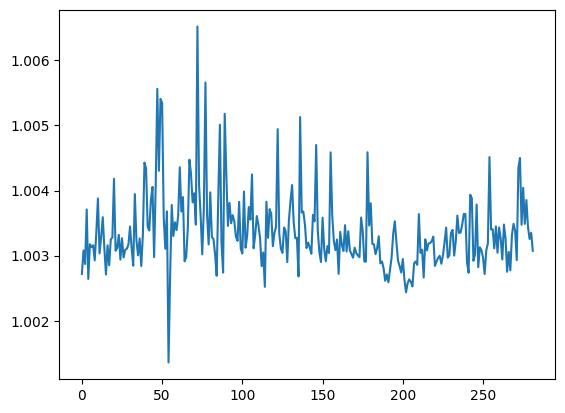

In [6]:
plt.plot(dkist_dataset.headers['DATARMS'].value/dkist_dataset.headers['DATAMEAN'].value)

In [7]:
dkist_dataset.data

dask.array<reshape, shape=(282, 4096, 4096), dtype=float32, chunksize=(1, 4096, 4096), chunktype=numpy.ndarray>

In [8]:
vbi_median_filtered = median_filter(dkist_dataset.data, size=(1,3,3), )

In [9]:
gradient_value_r = da.sum(da.sqrt(sobel(dkist_dataset.data, axis=1)**2 + sobel(dkist_dataset.data, axis=2)**2), axis=(1,2))

In [10]:
gradient_value_p = da.sum(da.sqrt(sobel(vbi_median_filtered, axis=1)**2 + sobel(vbi_median_filtered, axis=2)**2), axis=(1,2))

In [11]:
mfgs = (2*gradient_value_r*gradient_value_p)/(gradient_value_r**2 + gradient_value_p**2)

In [12]:
mfgs_compute = mfgs.compute()

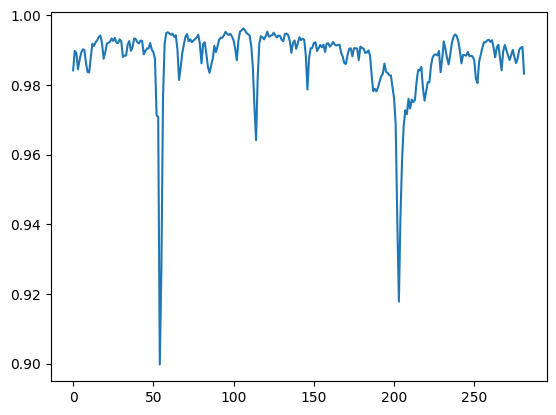

In [13]:
plt.plot(mfgs_compute)

In [14]:
np.save("./dask_sav/mfgs.npy",mfgs_compute)

In [15]:
vbi_rms_metric = da.std(dkist_dataset.data,axis=(1,2))/da.mean(dkist_dataset.data,axis=(1,2))
vbi_rms_metric = vbi_rms_metric.compute()

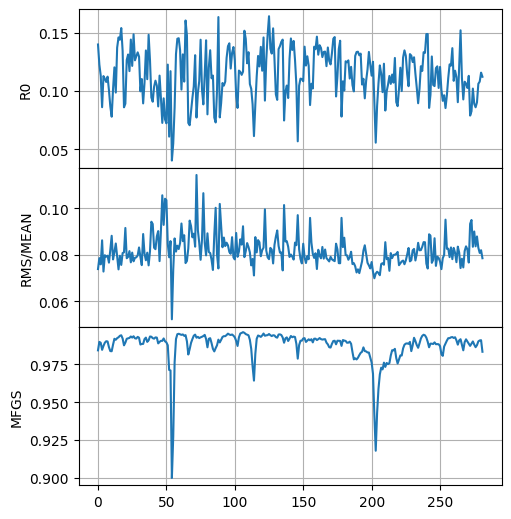

In [16]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(5,5),layout='constrained', sharex=True)

ax1.plot(dkist_dataset.headers['ATMOS_R0'].value)

ax2.plot(vbi_rms_metric)

ax3.plot(mfgs_compute)
ax3.set_ylim(top=0.99999)

ax1.set_ylabel("R0")
ax2.set_ylabel("RMS/MEAN")
ax3.set_ylabel("MFGS")

for ax_ in (ax1,ax2):
    ax_.tick_params(bottom=False,labelbottom=False)

for ax_ in (ax1,ax2,ax3):
    ax_.grid("on")

fig.get_layout_engine().set(hspace=0,h_pad=0)

In [17]:
np.argmax(dkist_dataset.headers['ATMOS_R0'].value)

125

In [48]:
best_indices = np.argsort(-dkist_dataset.headers['ATMOS_R0'].value)[:5]
best_indices

array([125,  88,  64,  17, 128])

In [49]:
dkist_dataset.headers['ATMOS_R0'].value[best_indices]

array([0.16397389, 0.16325374, 0.16031398, 0.15382904, 0.15358366])

In [94]:
bad_indices = np.where(dkist_dataset.headers['ATMOS_R0'].value < 0.08)[0]
bad_indices, len(bad_indices)

(array([ 10,  47,  49,  50,  52,  54,  55,  66,  67,  72,  80,  85,  86,
         89, 114, 136, 146, 178, 203, 272]),
 20)

In [67]:
dkist_dataset.headers['FILENAME'][125]

'VBI_2022_10_24T19_18_16_186_00486136_I_BJOLO_L1.fits'

In [18]:
vbi_img_fft_mag = da.fft.fftshift(da.abs(da.fft.fftn(dkist_dataset.data[125,:,:]))).compute()

In [34]:
vbi_img_fft_freq = np.fft.fftshift(np.fft.fftfreq(4096))

In [37]:
freq_interval = np.nanmean(np.diff(vbi_img_fft_freq))

In [42]:
vbi_freq_extent = [vbi_img_fft_freq[0] - freq_interval, vbi_img_fft_freq[-1] + freq_interval, 
                   vbi_img_fft_freq[0] - freq_interval, vbi_img_fft_freq[-1] + freq_interval]

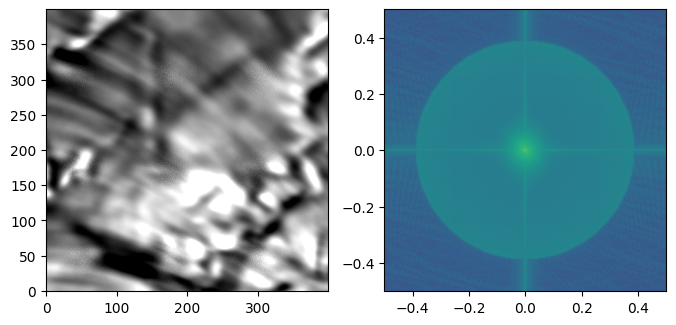

In [43]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,4))

ax1.imshow(dkist_dataset.data[125,2000:2400,2000:2400], norm=ImageNormalize(vmin=np.nanpercentile(dkist_dataset.data[125,:,:].compute(),1),
                                                            vmax=np.nanpercentile(dkist_dataset.data[125,:,:].compute(),99)),
            origin="lower",cmap="gray")

ax2.imshow(np.log10(vbi_img_fft_mag), extent=vbi_freq_extent, origin="lower")

(-0.1, 0.1)

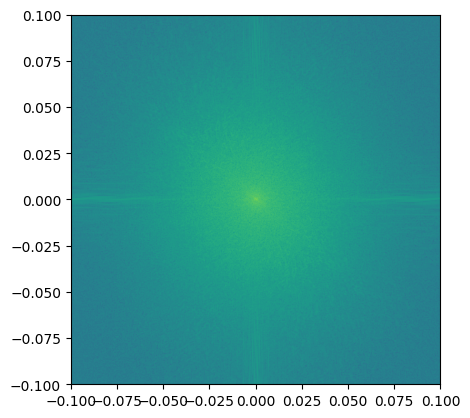

In [69]:
fig, ax = plt.subplots()
ax.imshow(np.log10(vbi_img_fft_mag), extent=vbi_freq_extent, origin="lower")
ax.set_xlim(-0.1,0.1)
ax.set_ylim(-0.1,0.1)

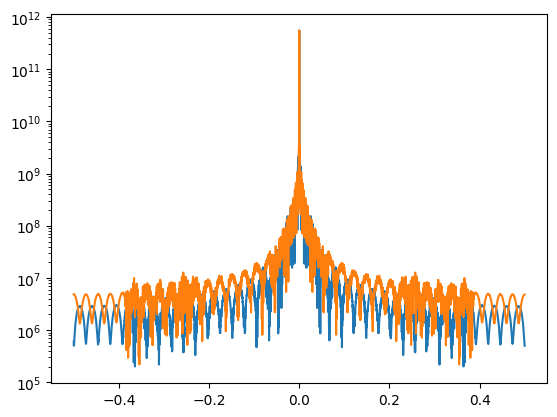

In [89]:
fig, ax = plt.subplots()
ax.plot(vbi_img_fft_freq, vbi_img_fft_mag[:,2048])
ax.plot(vbi_img_fft_freq, vbi_img_fft_mag[2048,:])
ax.set_yscale("log")

In [83]:
vbi_img_fft_freq_x, vbi_img_fft_freq_y = np.meshgrid(vbi_img_fft_freq, vbi_img_fft_freq)
vbi_img_fft_freq_r = np.sqrt(vbi_img_fft_freq_x**2 + vbi_img_fft_freq_y**2)

In [84]:
f = lambda r : vbi_img_fft_mag[(vbi_img_fft_freq_r >= r-.5*freq_interval) & (vbi_img_fft_freq_r < r+.5*freq_interval)].mean()
r  = vbi_img_fft_freq[2048:]
vbi_img_fft_mag_rmean = np.vectorize(f)(r)

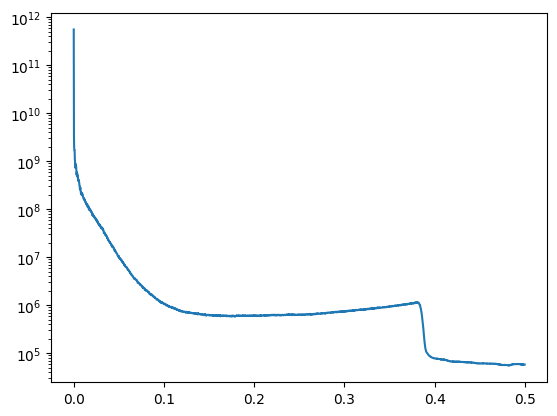

In [88]:
fig, ax = plt.subplots()
ax.plot(r, vbi_img_fft_mag_rmean)
ax.set_yscale("log")